# 1. Introduction
One of the primary applications of natural language processing is to automatically extract what topics people are discussing from large volumes of text. Some examples of large text could be feeds from social media, customer reviews of hotels, movies, etc, user feedbacks, news stories, e-mails of customer complaints etc.

Knowing what people are talking about and understanding their problems and opinions is highly valuable to businesses, administrators, political campaigns. And it’s really hard to manually read through such large volumes and compile the topics.

Thus is required an automated algorithm that can read through the text documents and automatically output the topics discussed.

In this tutorial, we will take a real example of the ’20 Newsgroups’ dataset and use LDA to extract the naturally discussed topics.

I will be using the Latent Dirichlet Allocation (LDA) from Gensim package along with the Mallet’s implementation (via Gensim). Mallet has an efficient implementation of the LDA. It is known to run faster and gives better topics segregation.

We will also extract the volume and percentage contribution of each topic to get an idea of how important a topic is.

Let’s begin!

Source: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

# 2. Prerequisites – Download nltk stopwords and spacy model
We will need the stopwords from NLTK and spacy’s en model for text pre-processing. Later, we will be using the spacy model for lemmatization.

Lemmatization is nothing but converting a word to its root word.  
For example: the lemma of the word ‘machines’ is ‘machine’.   
Likewise, ‘walking’ –> ‘walk’,   
‘mice’ –> ‘mouse’ and so on.

In [1]:
# Run in python console
import nltk #; nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/briansum/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Run in terminal or command prompt
#!python -m spacy download en

# 3. Import Packages
The core packages used in this tutorial are re, gensim, spacy and pyLDAvis. Besides this we will also using matplotlib, numpy and pandas for data handling and visualization. Let’s import them.

In [3]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [4]:
#!pip install pyLDAvis

# 4. What does LDA do?
LDA’s approach to topic modeling is it considers each document as a collection of topics in a certain proportion. And each topic as a collection of keywords, again, in a certain proportion.

Once you provide the algorithm with the number of topics, all it does it to rearrange the topics distribution within the documents and keywords distribution within the topics to obtain a good composition of topic-keywords distribution.

When I say topic, what is it actually and how it is represented?

A topic is nothing but a collection of dominant keywords that are typical representatives. Just by looking at the keywords, you can identify what the topic is all about.

The following are key factors to obtaining good segregation topics:

The quality of text processing.
The variety of topics the text talks about.
The choice of topic modeling algorithm.
The number of topics fed to the algorithm.
The algorithms tuning parameters.

# 5. Prepare Stopwords
We have already downloaded the stopwords. Let’s import them and make it available in stop_words.

In [5]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

# 6. Import Data

In [6]:
# Import Dataset
df=pd.read_csv('Illumina Inc_20170131-Text.txt', sep='\t', header=None, names = ["text"])

In [7]:
print(df.head())

                                                text
0                                 Thank you, Francis
1  As Francis mentioned, Q4 revenue grew 5% year-...
2  As a result of growth in our installed base, i...
3  MiSeq pull-through was in our projected range ...
4  HiSeq and HiSeq X utilization were within thei...


# 7. Cleaning Data
As you can see there are many noise characters and extra spaces that is quite distracting. Let’s get rid of them using regular expressions.

In [8]:
# Convert to list
data = df.text.values.tolist()

In [9]:
# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

In [10]:
# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

In [11]:
# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

In [12]:
pprint(data[:1])

['Thank you, Francis']


After removing the stopwords and extra spaces, the text still looks messy. It is not ready for the LDA to consume. You need to break down each sentence into a list of words through tokenization, while clearing up all the messy text in the process.

Gensim’s simple_preprocess is great for this.

# 8. Tokenize words and Clean-up text
Let’s tokenize each sentence into a list of words, removing punctuations and unnecessary characters altogether.

Gensim’s simple_preprocess() is great for this. Additionally I have set deacc=True to remove the punctuations.

In [13]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

In [14]:
print(data_words[:2])

[['thank', 'you', 'francis'], ['as', 'francis', 'mentioned', 'revenue', 'grew', 'year', 'over', 'year', 'to', 'million', 'consistent', 'with', 'our', 'preliminary', 'estimates', 'on', 'january', 'fourth', 'quarter', 'consumable', 'revenue', 'represented', 'of', 'total', 'revenue', 'or', 'million', 'an', 'increase', 'of', 'compared', 'to', 'the', 'fourth', 'quarter', 'of', 'sequencing', 'consumable', 'revenue', 'grew', 'year', 'over', 'year', 'to', 'million']]


# 9. Creating Bigram and Trigram Models
Bigrams are two words frequently occurring together in the document. Trigrams are 3 words frequently occurring.

Some examples in our example are: ‘front_bumper’, ‘oil_leak’, ‘maryland_college_park’ etc.

Gensim’s Phrases model can build and implement the bigrams, trigrams, quadgrams and more. The two important arguments to Phrases are min_count and threshold. The higher the values of these param, the harder it is for words to be combined to bigrams.

In [15]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [16]:
# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['thank', 'you', 'francis']


# 10. Remove Stopwords, Make Bigrams and Lemmatize
The bigrams model is ready. Let’s define the functions to remove the stopwords, make bigrams and lemmatization and call them sequentially.

In [17]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [18]:
# Let’s call the functions in order.

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

In [19]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

In [20]:
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:2])

[['thank'], ['mention', 'revenue', 'grow', 'year', 'year', 'consistent', 'preliminary', 'estimate', 'fourth', 'quarter', 'consumable', 'revenue', 'represent', 'total', 'revenue', 'increase', 'compare', 'fourth', 'quarter', 'sequence', 'consumable', 'revenue', 'grow', 'year', 'year']]


# 11. Create the Dictionary and Corpus needed for Topic Modeling
The two main inputs to the LDA topic model are the dictionary(id2word) and the corpus. Let’s create them.

In [21]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [22]:
# View
print(corpus[:2])

[[(0, 1)], [(1, 1), (2, 1), (3, 2), (4, 1), (5, 2), (6, 2), (7, 1), (8, 1), (9, 1), (10, 2), (11, 1), (12, 4), (13, 1), (14, 1), (15, 4)]]


Gensim creates a unique id for each word in the document. The produced corpus shown above is a mapping of (word_id, word_frequency).

For example, (0, 1) above implies, word id 0 occurs once in the first document. Likewise, word id 1 occurs twice and so on.

This is used as the input by the LDA model.

If you want to see what word a given id corresponds to, pass the id as a key to the dictionary.

id2word[0]
'addition'
Or, you can see a human-readable form of the corpus itself.

In [23]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:2]]

[[('thank', 1)],
 [('compare', 1),
  ('consistent', 1),
  ('consumable', 2),
  ('estimate', 1),
  ('fourth', 2),
  ('grow', 2),
  ('increase', 1),
  ('mention', 1),
  ('preliminary', 1),
  ('quarter', 2),
  ('represent', 1),
  ('revenue', 4),
  ('sequence', 1),
  ('total', 1),
  ('year', 4)]]

Alright, without digressing further let’s jump back on track with the next step: Building the topic model.

# 12. Building the Topic Model
We have everything required to train the LDA model. In addition to the corpus and dictionary, you need to provide the number of topics as well.

Apart from that, **alpha** and **eta** are hyperparameters that affect sparsity of the topics. According to the Gensim docs, both defaults to 1.0/num_topics prior.

**chunksize** is the number of documents to be used in each training chunk. **update_every** determines how often the model parameters should be updated and **passes** is the total number of training passes.

In [24]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# 13. View the topics in LDA model
The above LDA model is built with 20 different topics where each topic is a combination of keywords and each keyword contributes a certain weightage to the topic.

You can see the keywords for each topic and the weightage(importance) of each keyword using lda_model.print_topics() as shown next.

In [25]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())

[(0,
  '0.091*"gaap" + 0.052*"earning" + 0.052*"diluted" + 0.052*"share" + '
  '0.052*"non" + 0.027*"day" + 0.027*"ep" + 0.027*"expect" + 0.026*"expense" + '
  '0.014*"slightly"'),
 (1,
  '0.048*"really" + 0.048*"think" + 0.048*"consumable" + 0.046*"work" + '
  '0.024*"sample" + 0.024*"drive" + 0.024*"way" + 0.024*"good" + 0.024*"first" '
  '+ 0.024*"foremost"'),
 (2,
  '0.042*"increase" + 0.042*"revenue" + 0.042*"question" + 0.021*"quarter" + '
  '0.021*"adjust" + 0.021*"equal" + 0.021*"development" + 0.021*"adjusted" + '
  '0.021*"full" + 0.021*"expense"'),
 (3,
  '0.059*"hiseq" + 0.044*"customer" + 0.040*"instrument" + 0.030*"quarter" + '
  '0.030*"include" + 0.030*"novaseq" + 0.030*"take" + 0.030*"fully" + '
  '0.029*"few" + 0.021*"go"'),
 (4,
  '0.042*"consumable" + 0.042*"sequence" + 0.028*"year" + 0.028*"revenue" + '
  '0.028*"prior" + 0.028*"number" + 0.028*"sample" + 0.015*"include" + '
  '0.015*"grail" + 0.015*"result"'),
 (5,
  '0.003*"prior" + 0.003*"hence" + 0.003*"less" +

In [26]:
doc_lda = lda_model[corpus]

How to interpret this?

Topic 0 is a represented as _0.016“car” + 0.014“power” + 0.010“light” + 0.009“drive” + 0.007“mount” + 0.007“controller” + 0.007“cool” + 0.007“engine” + 0.007“back” + ‘0.006“turn”.

It means the top 10 keywords that contribute to this topic are: ‘car’, ‘power’, ‘light’.. and so on and the weight of ‘car’ on topic 0 is 0.016.

The weights reflect how important a keyword is to that topic.

Looking at these keywords, can you guess what this topic could be? You may summarise it either are ‘cars’ or ‘automobiles’.

Likewise, can you go through the remaining topic keywords and judge what the topic is?

Inferring Topic from Keywords
Inferring Topic from Keywords

# 14. Compute Model Perplexity and Coherence Score
Model perplexity and topic coherence provide a convenient measure to judge how good a given topic model is. In my experience, topic coherence score, in particular, has been more helpful.

In [27]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.


Perplexity:  -6.437717246496631


In [28]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

/Users/briansum/opt/anaconda3/envs/TPML/lib/python3.7/site-packages/scipy/sparse/lil.py:504: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not i.flags.writeable or i.dtype not in (np.int32, np.int64):
/Users/briansum/opt/anaconda3/envs/TPML/lib/python3.7/site-packages/scipy/sparse/lil.py:506: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not j.flags.writeable or j.dtype not in (np.int32, np.int64):



Coherence Score:  0.39467909327020706


# 15. Visualize the topics-keywords
Now that the LDA model is built, the next step is to examine the produced topics and the associated keywords. There is no better tool than pyLDAvis package’s interactive chart and is designed to work well with jupyter notebooks.

In [29]:
# Visualize the topics
pyLDAvis.enable_notebook()

In [32]:
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/Users/briansum/opt/anaconda3/envs/TPML/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10    -0.104981 -0.155873       1        1  15.634624
18    -0.089638  0.121930       2        1   8.666393
14     0.070705 -0.157635       3        1   8.264288
0     -0.201174 -0.042369       4        1   7.661594
4     -0.004532  0.045054       5        1   7.060765
3      0.074126 -0.052821       6        1   6.542853
12     0.084446 -0.104465       7        1   6.416438
8     -0.130256  0.022316       8        1   5.079762
13    -0.134070 -0.020196       9        1   5.074910
16     0.036922  0.105855      10        1   4.651438
2     -0.113245  0.033464      11        1   4.058526
11     0.115303 -0.021515      12        1   3.734490
7      0.027407  0.123723      13        1   3.673290
1      0.089388  0.081202      14        1   3.427068
17     0.089375  0.012572      15        1   2.342724
19     0.009657  0.001399      16        1   2.331385
6      0.062420  0.034238      17        1   1.937906
9      0.041947 -0.046813      18        1   1.937886
15     0.047691  0.008449      19        1   1.295231
5      0.028511  0.011486      20        1   0.208424, topic_info=    Category       Freq       Term      Total  loglift  logprob
70   Default  11.000000       gaap  11.000000  30.0000  30.0000
21   Default   5.000000      hiseq   5.000000  29.0000  29.0000
12   Default  10.000000    revenue  10.000000  28.0000  28.0000
10   Default  13.000000    quarter  13.000000  27.0000  27.0000
15   Default  11.000000       year  11.000000  26.0000  26.0000
..       ...        ...        ...        ...      ...      ...
109  Topic20   0.004693     absorb   1.370159   0.4966  -5.8464
107  Topic20   0.004693  operation   2.034035   0.1016  -5.8464
86   Topic20   0.004693     review   1.315703   0.5372  -5.8464
89   Topic20   0.004693     income   2.471405  -0.0932  -5.8464
90   Topic20   0.004693        net   2.471405  -0.0932  -5.8464

[850 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
198       3  0.720697     ability
109       6  0.729842      absorb
313       1  0.673428     account
171       2  0.706212  accounting
116       1  0.643436     accrual
...     ...       ...         ...
15        5  0.169612        year
15        6  0.084806        year
15        7  0.169612        year
15        9  0.084806        year
15       15  0.084806        year

[605 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 19, 15, 1, 5, 4, 13, 9, 14, 17, 3, 12, 8, 2, 18, 20, 7, 10, 16, 6])

So how to infer pyLDAvis’s output?

Each bubble on the left-hand side plot represents a topic. The larger the bubble, the more prevalent is that topic.

A good topic model will have fairly big, non-overlapping bubbles scattered throughout the chart instead of being clustered in one quadrant.

A model with too many topics, will typically have many overlaps, small sized bubbles clustered in one region of the chart.

Alright, if you move the cursor over one of the bubbles, the words and bars on the right-hand side will update. These words are the salient keywords that form the selected topic.

We have successfully built a good looking topic model.

Given our prior knowledge of the number of natural topics in the document, finding the best model was fairly straightforward.

Upnext, we will improve upon this model by using Mallet’s version of LDA algorithm and then we will focus on how to arrive at the optimal number of topics given any large corpus of text.

# 16. Building LDA Mallet Model
So far you have seen Gensim’s inbuilt version of the LDA algorithm. Mallet’s version, however, often gives a better quality of topics.

Gensim provides a wrapper to implement Mallet’s LDA from within Gensim itself. You only need to download the zipfile, unzip it and provide the path to mallet in the unzipped directory to gensim.models.wrappers.LdaMallet. See how I have done this below.

In [34]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
# mallet_path = '/mallet' # update this path for the zip file
# ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

# Show Topics
#pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
#coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
#coherence_ldamallet = coherence_model_ldamallet.get_coherence()
#print('\nCoherence Score: ', coherence_ldamallet)

# 17. How to find the optimal number of topics for LDA?
My approach to finding the optimal number of topics is to build many LDA models with different values of number of topics (k) and pick the one that gives the highest coherence value.

Choosing a ‘k’ that marks the end of a rapid growth of topic coherence usually offers meaningful and interpretable topics. Picking an even higher value can sometimes provide more granular sub-topics.

If you see the same keywords being repeated in multiple topics, it’s probably a sign that the ‘k’ is too large.

The compute_coherence_values() (see below) trains multiple LDA models and provides the models and their corresponding coherence scores.

In [35]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []

    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [36]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

/Users/briansum/opt/anaconda3/envs/TPML/lib/python3.7/site-packages/scipy/sparse/lil.py:504: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not i.flags.writeable or i.dtype not in (np.int32, np.int64):
/Users/briansum/opt/anaconda3/envs/TPML/lib/python3.7/site-packages/scipy/sparse/lil.py:506: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not j.flags.writeable or j.dtype not in (np.int32, np.int64):


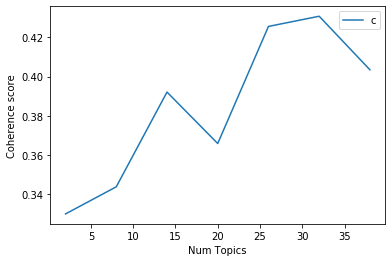

In [37]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [38]:
# Choosing the optimal number of LDA topics
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3301
Num Topics = 8  has Coherence Value of 0.3439
Num Topics = 14  has Coherence Value of 0.3921
Num Topics = 20  has Coherence Value of 0.3659
Num Topics = 26  has Coherence Value of 0.4255
Num Topics = 32  has Coherence Value of 0.4307
Num Topics = 38  has Coherence Value of 0.4035


If the coherence score seems to keep increasing, it may make better sense to pick the model that gave the highest CV before flattening out. This is exactly the case here.

So for further steps I will choose the model with 32 topics itself.

In [40]:
# Select the model and print the topics
optimal_model = model_list[5] # Count from index 0 (top)
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(23,
  '0.052*"well" + 0.041*"margin" + 0.041*"business" + 0.021*"gross" + '
  '0.021*"adjusted" + 0.021*"accrual" + 0.021*"discuss" + 0.021*"see" + '
  '0.021*"operate" + 0.021*"cite"'),
 (21,
  '0.044*"work" + 0.023*"place" + 0.023*"point" + 0.023*"range" + '
  '0.023*"sense" + 0.023*"hand" + 0.023*"look" + 0.023*"eventually" + '
  '0.023*"buy" + 0.023*"experiment"'),
 (18,
  '0.073*"expense" + 0.073*"non" + 0.037*"exclude" + 0.037*"gaap" + '
  '0.037*"turn" + 0.037*"margin" + 0.037*"adjust" + 0.037*"result" + '
  '0.037*"cash" + 0.037*"item"'),
 (19,
  '0.040*"subsequent" + 0.040*"earning" + 0.040*"share" + 0.040*"result" + '
  '0.040*"reference" + 0.040*"flow" + 0.040*"stockholder" + 0.040*"free" + '
  '0.040*"income" + 0.040*"net"'),
 (16,
  '0.029*"impact" + 0.029*"approximately" + 0.029*"authorization" + '
  '0.029*"quarter" + 0.029*"share" + 0.029*"point" + 0.029*"remain" + '
  '0.029*"announce" + 0.029*"sure" + 0.029*"gain"'),
 (22,
  '0.049*"compensation" + 0.049*"margin" + 

Those were the topics for the chosen LDA model.

# 18. Finding the dominant topic in each sentence
One of the practical application of topic modeling is to determine what topic a given document is about.

To find that, we find the topic number that has the highest percentage contribution in that document.

The format_topics_sentences() function below nicely aggregates this information in a presentable table.

In [41]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [42]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

In [43]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

In [44]:
# Show Dominant Topic For Each Document
print(df_dominant_topic.head(10))

   Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0            0             0.0              0.0312   
1            1            10.0              0.9627   
2            2            11.0              0.9354   
3            3            12.0              0.9395   
4            4            13.0              0.9579   
5            5             5.0              0.9031   
6            6             9.0              0.7578   
7            7            26.0              0.9395   
8            8            18.0              0.9462   
9            9            17.0              0.9255   

                                            Keywords  \
0  prior, hence, less, headwind, current, currenc...   
1  year, revenue, fourth, grow, quarter, consumab...   
2  gain, range, base, utilization, guidance, grow...   
3  miniseq, equipment, increase, accounting, suit...   
4  instrument, contract, customer, decommission, ...   
5  result, margin, include, cash, rate, report, i...   
6  revenue, s

# 19. Find the most representative document for each topic
Sometimes just the topic keywords may not be enough to make sense of what a topic is about. So, to help with understanding the topic, you can find the documents a given topic has contributed to the most and infer the topic by reading that document. Whew!!

In [45]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

In [46]:
# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

In [47]:
# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

In [48]:
# Show Most Representative Topic For Each Document
print(sent_topics_sorteddf_mallet.head()) 

   Topic_Num  Topic_Perc_Contrib  \
0        0.0              0.0312   
1        1.0              0.9430   
2        2.0              0.7578   
3        3.0              0.9308   
4        4.0              0.7578   

                                            Keywords  \
0  prior, hence, less, headwind, current, currenc...   
1  basis, point, gross, adjust, product, family, ...   
2  see, sight, may, end, depend, contribution, he...   
3  day, total, collection, compare, due, benefit,...   
4  factor, depend, lot, currency, contribution, s...   

                                                Text  
0                                 Thank you, Francis  
1  Our adjusted gross margin for the fourth quart...  
2                We dont see an end in sight to that  
3  Q4 DSO totaled 56 days, down slightly compared...  
4             I mean, it depends on a lot of factors  


The tabular output above actually has 20 rows, one each for a topic. It has the topic number, the keywords, and the most representative document. The Perc_Contribution column is nothing but the percentage contribution of the topic in the given document.

# 20. Topic distribution across documents
Finally, we want to understand the volume and distribution of topics in order to judge how widely it was discussed. The below table exposes that information.

In [49]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

In [50]:
# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

In [51]:
# Topic Number and Keywords
topic_num_keywords = sent_topics_sorteddf_mallet[['Topic_Num', 'Keywords']]

In [52]:
# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts.sort_index(), topic_contribution.sort_index()], axis=1)

In [53]:
# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

In [54]:
# Show Topic Volume Distribution
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,0.0,"prior, hence, less, headwind, current, currenc...",1.0,0.0154
1.0,1.0,"basis, point, gross, adjust, product, family, ...",1.0,0.0154
2.0,2.0,"see, sight, may, end, depend, contribution, he...",2.0,0.0308
3.0,3.0,"day, total, collection, compare, due, benefit,...",1.0,0.0154
4.0,4.0,"factor, depend, lot, currency, contribution, s...",1.0,0.0154
5.0,5.0,"result, margin, include, cash, rate, report, i...",4.0,0.0615
6.0,7.0,"s, hiseq, growth, expect, there, grail, agency...",NaN,NaN
7.0,8.0,"quarter, investment, several, fully, support, ...",4.0,0.0615
8.0,9.0,"revenue, service, equal, contribution, currenc...",3.0,0.0462
9.0,10.0,"year, revenue, fourth, grow, quarter, consumab...",1.0,0.0154


# 21. Conclusion
We started with understanding what topic modeling can do. We built a basic topic model using Gensim’s LDA and visualize the topics using pyLDAvis. Then we built mallet’s LDA implementation. You saw how to find the optimal number of topics using coherence scores and how you can come to a logical understanding of how to choose the optimal model.

Finally we saw how to aggregate and present the results to generate insights that may be in a more actionable.

Hope you enjoyed reading this. I would appreciate if you leave your thoughts in the comments section below.

Edit: I see some of you are experiencing errors while using the LDA Mallet and I don’t have a solution for some of the issues. So, I’ve implemented a workaround and more useful topic model visualizations. Hope you will find it helpful.